# CHiMaD Workshop: COVID-19 Example Notebook

In [1]:
import pandas as pd
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
from rdkit import Chem
import os
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from dlhub_sdk.client import DLHubClient
from mdf_forge import Forge
%matplotlib inline

### Retrieving Data with MDF Forge

In [2]:
'''mdf = Forge('mdf-test')

dataset_name = "anl_covid19_2020"
r = mdf.match_resource_types("record").match_source_names(dataset_name)
r = r.search()
print(r)'''

'mdf = Forge(\'mdf-test\')\n\ndataset_name = "anl_covid19_2020"\nr = mdf.match_resource_types("record").match_source_names(dataset_name)\nr = r.search()\nprint(r)'

In [3]:
df = pd.DataFrame()
#for i in list(sorted(os.listdir('test_all')))[:-1]:
for i in os.listdir('test_all'):
    if 'test' in i:
        try:
            tmp = pd.read_json('test_all/'+str(i),lines=True)
            df = df.append(tmp,ignore_index=True,sort=True)
        except:
            pass
df.head()

,AATS0Z,AATS0are,AATS0d,AATS0dv,AATS0i,AATS0m,AATS0p,AATS0pe,AATS0s,AATS0se,...,piPC6,piPC7,piPC8,piPC9,pubchem_id,smiles,synonyms,tpsa,vendor,xlogp
0,24.666667,6.479012,3.176471,8.980392,164.241022,97.495295,1.443441,6.522831,5.984749,7.964346,...,5.695834,6.047815,6.230850,6.226784,2536,CN(C(=O)COC(=O)Cc1ccc(cc1)OC(=O)c1ccc(cc1)N=C(...,[Camostat],137.0,NaN,1.1
1,25.846154,6.725558,3.346154,9.307692,172.136612,102.238689,1.328398,6.735969,5.869658,8.151494,...,5.729135,6.032505,6.288142,5.851574,135413535,OCC(Cn1cnc2c1ncnc2N)O,"[DHPA (S)-9-(2,3-Dihydroxypropyl)adenine]",110.0,NaN,-1.5
2,14.764706,5.472497,2.911765,2.529412,165.177736,57.314790,1.294520,5.556224,1.858047,7.111046,...,4.290459,4.369448,4.110874,3.218876,5071,CC(C12CC3CC(C2)CC(C1)C3)N,[Rimantadine],26.0,NaN,2.6
3,33.062500,6.993072,3.125000,9.790895,170.612517,132.878373,1.537560,6.978203,8.857203,8.481970,...,4.853981,4.586242,4.762708,4.659895,54671008,OCC(Cn1ccc(nc1=O)N)OCP(=O)(O)O,[Cidofovir],146.0,NaN,-3.6
4,26.000000,6.796234,3.480519,9.532468,163.885863,102.772228,1.335768,6.806935,6.737374,8.309584,...,6.249613,6.515499,6.865370,7.256540,442439,OCC1OC(Oc2cc3OC(CC(=O)c3c(c2)O)c2ccc(c(c2)O)OC...,[Neohesperidin],234.0,NaN,-0.5


### Generating Useful Cuts on Molecule Data

In [4]:
df_inputs = df.drop(columns=['vendor','homo','lumo','synonyms','smiles',\
                             'pubchem_id','xlogp','inchi','inchi_key','iupac_name'])
df_inputs = df_inputs.apply(pd.to_numeric).dropna(axis=1)
input_vals = np.array(df_inputs.values)
output_vals = np.array(df['xlogp'].values)
print(input_vals.shape)
print(output_vals.shape)

(316, 1024)
(316,)


### Analysis of Features using PCA

In [5]:
chem_pca = PCA(n_components=2)
transform = chem_pca.fit_transform(input_vals[:,:500]).T

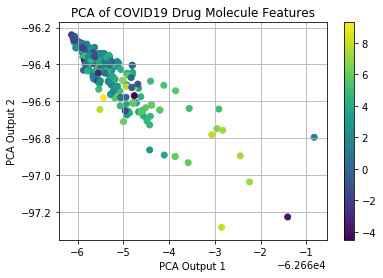

In [6]:
plt.figure()
plt.scatter(transform[0]/1000.,transform[1]/1000.,c=output_vals.tolist())
plt.colorbar()
plt.grid()
plt.xlabel('PCA Output 1')
plt.ylabel('PCA Output 2')
plt.title('PCA of COVID19 Drug Molecule Features')
plt.show()

### Visualizing Positive Results

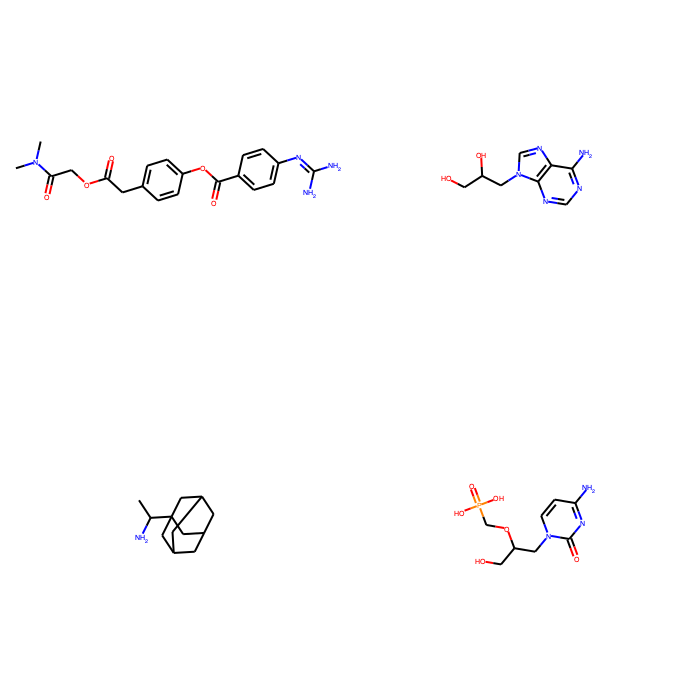

In [7]:
n_mols = 4
ms = [Chem.MolFromSmiles(sm) for sm in df['smiles'][0:n_mols]]
Chem.Draw.MolsToGridImage(ms,molsPerRow=2, subImgSize=(350, 350))

### Using DLHub to Run and Compare Models

In [9]:
DL = DLHubClient()

In [10]:
print(df['smiles'][0])

CN(C(=O)COC(=O)Cc1ccc(cc1)OC(=O)c1ccc(cc1)N=C(N)N)C


In [12]:
y_out_DL = DL.run(name = 'loganw_globusid/admet_tox', \
                  inputs=df['smiles'].tolist())

For Reference:

hERG I and II - a gene that codes for proteins controlling K-ion exchange in cell membranes

AMES I - a common bacterial toxicological test

Carc I - a common test for carcinogenicity (ability to cause cancer)

Based on this scale: score of 1 is most toxic, score of 0 is most benign.

In [24]:
tox_out = pd.DataFrame(np.array(list(y_out_DL.values())).T,columns=y_out_DL.keys())
tox_out.head()

,smiles,T_hERG_II,T_AMES_I,T_Carc_I,T_hERG_I
0,CN(C(=O)COC(=O)Cc1ccc(cc1)OC(=O)c1ccc(cc1)N=C(...,0.3766730614546943,0.1727067306558859,0.322438834040425,0.12280826064597285
1,OCC(Cn1cnc2c1ncnc2N)O,0.19896779145701676,0.6015104748693273,0.13226881138619703,0.13241346970563753
2,CC(C12CC3CC(C2)CC(C1)C3)N,0.08067164842284695,0.3462332723716513,0.0692546979724032,0.13313487130002913
3,OCC(Cn1ccc(nc1=O)N)OCP(=O)(O)O,0.24052601576518745,0.09202143455196388,0.16065251954250265,0.1607802069678012
4,OCC1OC(Oc2cc3OC(CC(=O)c3c(c2)O)c2ccc(c(c2)O)OC...,0.28892589195747925,0.30248856165990945,0.05533363434424185,0.14345901051853016


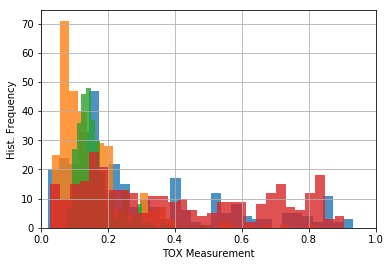

In [38]:
plt.figure()
plt.hist(np.array(tox_out['T_AMES_I'],dtype=np.float64),30,alpha=0.8)
plt.hist(np.array(tox_out['T_Carc_I'],dtype=np.float64),30,alpha=0.8)
plt.hist(np.array(tox_out['T_hERG_I'],dtype=np.float64),30,alpha=0.8,label='hERG')
plt.hist(np.array(tox_out['T_hERG_II'],dtype=np.float64),30,alpha=0.8,label='hERG')
plt.xlim([0,1])
plt.xlabel('TOX Measurement')
plt.ylabel('Hist. Frequency')
plt.grid()
plt.show()

In [40]:
#Put in min toxicity for all TOX metrics, use RDKit to show respective molecules
#Analysis based on structure, incorporating cuts with MDF Forge